## Hackathon

In [3]:
import xarray as xr
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.pyplot as plt
import statsmodels.api as sm

xr.set_options(display_style="text")

## Data loader om data uit de grote set te halen.

Gebruik `loader.get_subset()` voor specifieke ranges van tijd, longitude en latitude. 

Gebruik `subset.to_dataframe()` om een tabel van type xarray om te zetten naar een pandas dataframe. 

In [4]:
class DataLoader:
    """Simple dataloader for NetCDF temperature data."""
    
    def __init__(self, file_path):
        self.file_path = file_path
        self.dataset = None
    
    def load_data(self):
        """Load and preprocess the dataset."""
        self.dataset = xr.open_dataset(self.file_path, engine="h5netcdf")
        
        # Fix coordinates
        if self.dataset["longitude"].max() > 180:
            self.dataset = self.dataset.assign_coords(
                longitude=(self.dataset["longitude"].values + 180) % 360 - 180
            )
        if self.dataset["latitude"].max() > 90:
            self.dataset = self.dataset.assign_coords(
                latitude=self.dataset["latitude"].values - 90
            )
        
        # Sort coordinates
        self.dataset = self.dataset.sortby(["latitude", "longitude"])
        return self.dataset
    
    def get_subset(self, time_range=None, lat_range=None, lon_range=None):
        """Get a subset of the data."""
        if self.dataset is None:
            raise ValueError("Load data first!")
        
        subset = self.dataset
        if time_range:
            subset = subset.sel(valid_time=slice(time_range[0], time_range[1]))
        if lat_range:
            subset = subset.sel(latitude=slice(lat_range[0], lat_range[1]))
        if lon_range:
            subset = subset.sel(longitude=slice(lon_range[0], lon_range[1]))
        
        return subset.compute()
    


In [5]:
# Example usage
loader = DataLoader("2023_2m_temperature.nc")
dataset = loader.load_data()

In [6]:
print(dataset['longitude'].min().item())
print(dataset['longitude'].max().item())
print(dataset['latitude'].min().item())
print(dataset['latitude'].max().item())


-25.0
37.25
34.0
71.25


In [7]:
# Get a subset (May 2023, Europe)
subset = loader.get_subset(
    time_range=("2023-01-01", "2023-12-31"),
    lat_range=(52.25, 52.25),
    lon_range=(5.0, 5.0)
)
subset

min_time = dataset.valid_time.min().values
max_time = dataset.valid_time.max().values

min_lon = dataset.longitude.min().values
max_lon = dataset.longitude.max().values
min_lat = dataset.latitude.min().values
max_lat = dataset.latitude.max().values

print("Min time:", min_time)
print("Max time:", max_time)

print("Min lon:", min_lon)
print("Max lon:", max_lon)
print("Min lat:", min_lat)
print("Max lat:", max_lat)


Min time: 2023-01-01T00:00:00.000000000
Max time: 2023-12-31T23:00:00.000000000
Min lon: -25.0
Max lon: 37.25
Min lat: 34.0
Max lat: 71.25


In [8]:
subset["t2m"].data.flatten()[0:10]

array([287.72104, 287.52673, 287.25696, 286.77545, 285.91565, 285.18488,
       284.83664, 284.40027, 284.11185, 284.33044], dtype=float32)

In [9]:
subset_df = subset.to_dataframe().reset_index()
subset_df = subset_df.drop(['number', 'expver'], axis=1)
subset.to_dataframe()

mean_t2m = dataset['t2m'].sel(valid_time=slice("2023-05-01", "2023-05-31")).mean(dim='valid_time')

mean_t2m.head(10)


<xarray.DataArray 't2m' (latitude: 10, longitude: 10)>
array([[292.36533, 292.37976, 292.39536, 292.40985, 292.42346, 292.4164 ,
        292.4073 , 292.39465, 292.3907 , 292.3938 ],
       [292.29376, 292.29395, 292.302  , 292.3161 , 292.32867, 292.32608,
        292.3199 , 292.31174, 292.3013 , 292.2936 ],
       [292.2234 , 292.21774, 292.21832, 292.2219 , 292.22504, 292.23254,
        292.23364, 292.22736, 292.21704, 292.20502],
       [292.1427 , 292.14313, 292.14307, 292.14307, 292.14542, 292.14932,
        292.15042, 292.1447 , 292.1306 , 292.11514],
       [292.0662 , 292.07605, 292.07547, 292.0718 , 292.0739 , 292.06815,
        292.07257, 292.0755 , 292.06693, 292.03418],
       [292.0012 , 292.01117, 292.01672, 292.02026, 292.02765, 292.0151 ,
        292.00876, 292.00513, 292.0052 , 291.97565],
       [291.91922, 291.93338, 291.94107, 291.94635, 291.9487 , 291.9458 ,
        291.94055, 291.9346 , 291.92346, 291.89096],
       [291.8059 , 291.81635, 291.832  , 291.84048, 291.84723, 291.8532 ,
        291.84906, 291.8478 , 291.8465 , 291.82336],
       [291.70346, 291.7078 , 291.7215 , 291.72714, 291.73465, 291.74356,
        291.75967, 291.76126, 291.77145, 291.75778],
       [291.6207 , 291.62198, 291.60944, 291.6152 , 291.6217 , 291.63513,
        291.65103, 291.67233, 291.68567, 291.6781 ]], dtype=float32)
Coordinates:
    number     int64 ...
  * latitude   (latitude) float64 34.0 34.25 34.5 34.75 ... 35.75 36.0 36.25
  * longitude  (longitude) float64 -25.0 -24.75 -24.5 ... -23.25 -23.0 -22.75

In [10]:
fig = px.line(subset_df, x='valid_time', y='t2m')
fig.show()    


In [11]:

print(subset_df.columns)

Index(['valid_time', 'latitude', 'longitude', 't2m'], dtype='object')


## Methode om je forecast functie te evalueren op een random steekproef van de dataset. 
In dit voorbeeld wordt steeds 2 weken historische data gepakt en wordt 1 week vooruit voorspeld.

`generate_eval_data()` geeft n random periodes van 3 weken op willekeurige locaties.

`forecast(history, n_points)` neemt een historische reeks van temperaturen en voorspelt de volgende n_points.

`forecast_1w()` evalueert de forecast functie op een random week (MAE score) en toont een grafiek van de historische reeks, de echte waardes en de voorspelde waarde. 

`evaluator(function, n_samples)` berekent de mean absolute error (MAE) van de voorspelling van functie `forecast()` voor een steekproef van grootte n_samples. 

In [12]:
def generate_eval_data(n = 100):
    rng = np.random.default_rng()
    
    # ---- Random geolocation ----
    # Longitude uniform in [-180, 180)
    lon = rng.uniform(-25, 37.25, n)
    lon = np.round(lon * 4)/4
    
    # Latitude area-uniform: sample z = sin(lat) ~ U(-1,1)  => lat = arcsin(z)
    lat = rng.uniform(34, 71.25, n)
    lat = np.round(lat * 4)/4
    
    # ---- Random 3-week interval in 2023 ----
    start0 = pd.Timestamp("2023-01-01")
    # Inclusive end = start + 20 days (21 calendar days total)
    last_start = pd.Timestamp("2023-12-31") - pd.Timedelta(days=20)
    num_choices = (last_start - start0).days + 1
    
    offsets = rng.integers(0, num_choices, n)  # days after Jan 1
    start_date = start0 + pd.to_timedelta(offsets, unit="D")
    end_date = start_date + pd.Timedelta(days=20)
    
    # ---- Assemble DataFrame ----
    df = pd.DataFrame({
        "latitude_deg": lat,
        "longitude_deg": lon,
        "start_date": start_date.strftime("%Y-%m-%d"),
        "end_date": end_date.strftime("%Y-%m-%d")
    })

    return df

In [13]:
def generate_eval_data_non_rand(lon, lat, start_date=['2023-05-01'], end_date=['2023-05-21']):
    # ---- Assemble DataFrame ----
    df = pd.DataFrame({
        "latitude_deg": lat,
        "longitude_deg": lon,
        "start_date": start_date,
        "end_date": end_date
    })
    return df

In [14]:
generate_eval_data(5)

,latitude_deg,longitude_deg,start_date,end_date
0,53.75,24.25,2023-03-06,2023-03-26
1,54.00,2.25,2023-09-02,2023-09-22
2,58.50,8.50,2023-05-24,2023-06-13
3,48.25,-0.75,2023-03-21,2023-04-10
4,43.50,16.25,2023-09-04,2023-09-24


In [15]:
def AR1(history, lon = 40, lat = 25, start_date_hist = '2023-02-23', end_date_hist = '2023-03-08', n_points = 7*24):
    model = sm.tsa.ARIMA(history, order=(1, 0, 0)).fit()

    forecast = model.forecast(steps=n_points)
    return forecast

In [16]:
def forecast(history, lon = 40, lat = 25, start_date_hist = '2023-02-23', end_date_hist = '2023-03-08', n_points = 7*24):
    # Take the last point of the history and repeat it n_points times
    try:
        return np.full(n_points, history[-1])
    except: 
        return np.full(n_points, 0)

def forecast_1w(row, function, operation = 'loop'):
    sample = loader.get_subset(
            time_range=(row['start_date'], row['end_date']),
            lat_range=(row['latitude_deg'], row['latitude_deg']),
            lon_range=(row['longitude_deg'], row['longitude_deg'])
        ).compute()
    history = sample.sel(valid_time=slice(row['start_date'],(pd.to_datetime(row['start_date']) + pd.Timedelta(weeks=2)).strftime("%Y-%m-%d")))['t2m'].data.flatten()
    y_true = sample.sel(valid_time=slice((pd.to_datetime(row['start_date']) + pd.Timedelta(weeks=2)).strftime("%Y-%m-%d"),row['end_date']))['t2m'].data.flatten()
    y_pred = function(history, 
                      row['longitude_deg'], 
                      row['latitude_deg'], 
                      row['start_date'],
                      (pd.to_datetime(row['start_date']) + pd.Timedelta(weeks=2)).strftime("%Y-%m-%d"), 
                      len(y_true))
    if operation == 'manual':
        fig, ax = plt.subplots()
        ax.plot(range(len(history)), history, color = 'blue')
        ax.plot(range(len(history), len(history) + len(y_true)), y_true, color = 'blue', linestyle = 'dashed')
        ax.plot(range(len(history), len(history) + len(y_true)), y_pred, color = 'green', linestyle = (0, (1, 1)))
    return np.mean(np.abs(y_true - y_pred))

In [17]:
forecast(np.array([9,8,18]), n_points = 5)

array([18, 18, 18, 18, 18])

0.9464409797378186

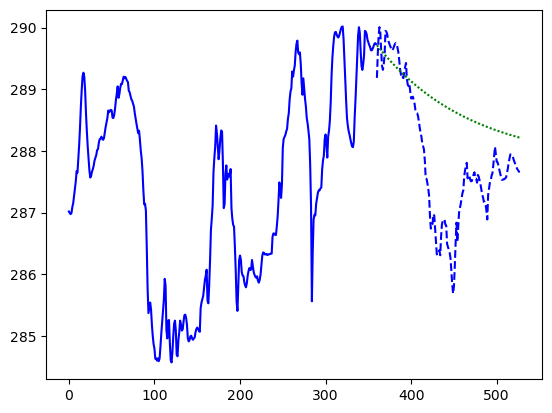

In [18]:
#forecast_1w(generate_eval_data(1).iloc[0], forecast, 'manual')
forecast_1w(generate_eval_data(1).iloc[0], AR1, 'manual')

In [19]:
def evaluator(function, n_samples = 100):
    errors = []
    df = generate_eval_data(n_samples)
    for index, row in df.iterrows():
        error = forecast_1w(row, function, operation = 'loop')
        errors.append(error)
    return np.mean(errors), row

In [ ]:
%pip install geopandas cartopy shapely tqdm


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/338.4 kB ? eta -:--:--
   ---------------------------------------- 0.0/338.4 kB ? eta -:--:--
   - -------------------------------------- 10.2/338.4 kB ? eta -:--:--
   ---- ---------------------------------- 41.0/338.4 kB 393.8 kB/s eta 0:00:01
   ---------------------------------------  337.9/338.4 kB 3.0 MB/s eta 0:00:01
   ---------------------------------------- 338.4/338.4 kB 2.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/19.2 MB ? eta -:--:--
   -- ------------------------------------- 1.0/19.2 MB 20.9 MB/s eta 0:00:01
   ---- ----------------------------------- 2.0/19.2 MB 20.7 MB/s eta 0:00:01
   ------ --------------------------------- 2.9/19.2 MB 20.5 MB/s eta 0:00:01
   ------ --------------------------------- 3.3/19.2 MB 21.1 MB/s eta 0:00:01
   ------- -------------------------------- 3.5/19.2 MB 14.7 MB/s eta 0:00:02
   -----

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import box
from tqdm import tqdm  # geeft een voortgangsbalk


In [ ]:
# eventjes kijken als het werkt
df_errors = pd.read_csv('error_map.csv')
df_errors.head()

,latitude_deg,longitude_deg,error
0,34.0,-25.00,0.432610
1,34.0,-24.75,0.444589
2,34.0,-24.50,0.446087
3,34.0,-24.25,0.464148
4,34.0,-24.00,0.479168


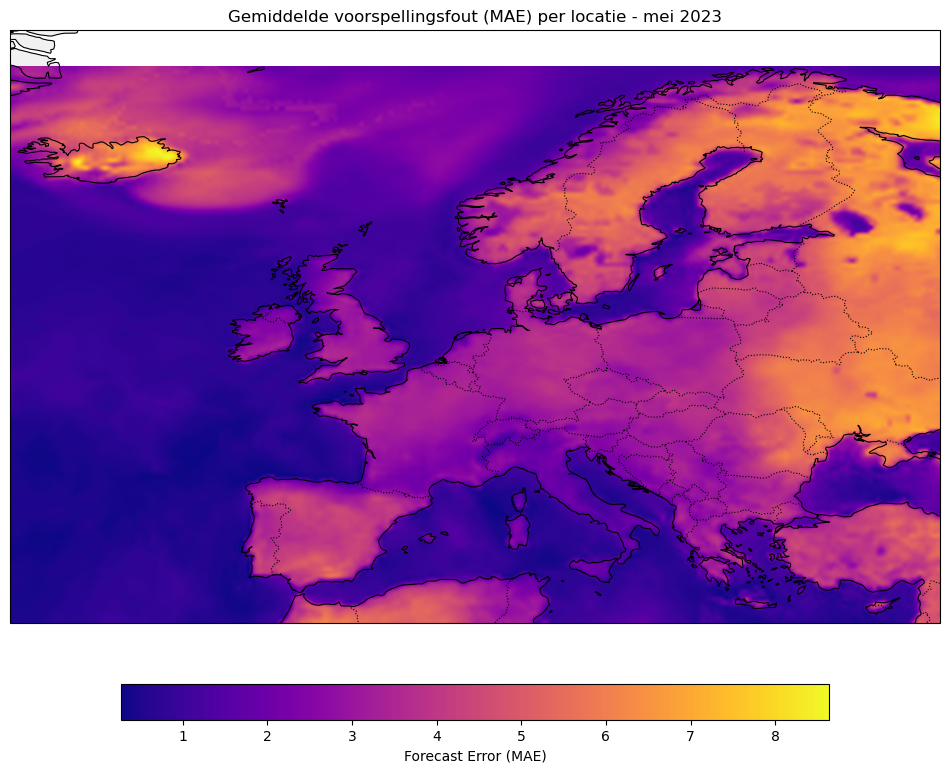

In [ ]:

# CSV inladen
df_errors = pd.read_csv('error_map.csv')
lats = np.sort(df_errors['latitude_deg'].unique())
lons = np.sort(df_errors['longitude_deg'].unique())
errors_grid = df_errors.pivot(index='latitude_deg', columns='longitude_deg', values='error').values

# Kaart
fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([lons.min(), lons.max(), lats.min(), lats.max()])

# Heatmap met vloeiende kleuren
img = ax.imshow(
    errors_grid,
    extent=(lons.min(), lons.max(), lats.min(), lats.max()),
    origin='lower',
    cmap='plasma',
    interpolation='spline36',  # vloeiende overgang
    transform=ccrs.PlateCarree()
)

# Land met lichte transparantie
ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.3)  # alpha = 0.3 maakt het transparant
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.8)
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)

# Horizontale colorbar, even breed als plot
cbar = fig.colorbar(img, ax=ax, orientation='horizontal', fraction=0.046, pad=0.08)
cbar.set_label('Forecast Error (MAE)')

# Titel
ax.set_title("Gemiddelde voorspellingsfout (MAE) per locatie - mei 2023")

plt.show()


In [ ]:
import pandas as pd
import requests
import numpy as np
import time
import random
from tqdm.notebook import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
import os

# ------------------------------
# CONFIGURATIE
# ------------------------------
batch_size = 200          # punten per batch
delay = 1.5               # basisdelay
max_retries = 7           # max pogingen bij 429
parallel_batches = 10     # aantal parallelle threads
output_file = 'error_map_with_elevation_parallel10.csv'

lat_col, lon_col = 'latitude_deg', 'longitude_deg'

# ------------------------------
# FUNCTIES
# ------------------------------
def fetch_batch(start, end, df, lat_col, lon_col, max_retries=7):
    """
    Haalt hoogtes op voor een batch met retries bij 429
    """
    batch = df.iloc[start:end]
    if batch['elevation'].notna().all():
        return start, end, batch['elevation'].tolist()  # al opgehaald

    retries = 0
    while retries <= max_retries:
        locations = "|".join([f"{lat},{lon}" for lat, lon in zip(batch[lat_col], batch[lon_col])])
        url = f"https://api.open-elevation.com/api/v1/lookup?locations={locations}"
        try:
            response = requests.get(url, timeout=20)
            if response.status_code == 200:
                results = response.json().get('results', [])
                elevations = [res.get('elevation', np.nan) for res in results]
                return start, end, elevations
            elif response.status_code == 429:
                retries += 1
                wait_time = 10 + 5*retries
                print(f"⚠️ Batch {start}-{end} 429, wacht {wait_time}s...", flush=True)
                time.sleep(wait_time)
            else:
                print(f"⚠️ Batch {start}-{end} API fout {response.status_code}", flush=True)
                return start, end, [np.nan]*len(batch)
        except Exception as e:
            print(f"⚠️ Batch {start}-{end} Fout: {e}", flush=True)
            return start, end, [np.nan]*len(batch)

    # Als max retries bereikt
    return start, end, [np.nan]*len(batch)

def categorize_elevation(elev):
    if pd.isna(elev):
        return "Onbekend"
    elif elev <= 0:
        return "Zee"
    elif elev < 100:
        return "Laagland"
    elif elev < 500:
        return "Heuvelland"
    elif elev < 1000:
        return "Middelgebergte"
    else:
        return "Hooggebergte"

# ------------------------------
# DATA LADEN
# ------------------------------
df = pd.read_csv('error_map.csv')
print(f"✅ Data geladen: {len(df)} punten", flush=True)
if 'elevation' not in df.columns:
    df['elevation'] = np.nan

# ------------------------------
# PARALLELE HOOGTES OPHALEN MET 10 THREADS
# ------------------------------
total_points = len(df)
batches = [(i, min(i+batch_size, total_points)) for i in range(0, total_points, batch_size)]
batch_times = []

with ThreadPoolExecutor(max_workers=parallel_batches) as executor:
    futures = {executor.submit(fetch_batch, start, end, df, lat_col, lon_col, max_retries): (start, end) for start, end in batches}
    
    for i, future in enumerate(tqdm(as_completed(futures), total=len(futures), desc="Batches verwerkt")):
        start, end, elevations = future.result()
        df.loc[start:end-1, 'elevation'] = elevations
        
        # Opslaan na elke batch
        df.to_csv(output_file, index=False)

        # Random kleine delay
        rand_delay = delay + random.uniform(-0.5, 0.5)
        if rand_delay < 0.5:
            rand_delay = 0.5
        time.sleep(rand_delay)

        # Gemiddelde batchtijd en geschatte resterende tijd
        batch_times.append(rand_delay)
        avg_time = sum(batch_times) / len(batch_times)
        remaining_batches = len(batches) - (i+1)
        est_remaining = remaining_batches * avg_time
        print(f"⏱ Geschatte resterende tijd: {est_remaining/60:.1f} min", flush=True)

# ------------------------------
# CATEGORISATIE


✅ Data geladen: 37500 punten
⚠️ Batch 600-800 429, wacht 15s...⚠️ Batch 400-600 429, wacht 15s...

⚠️ Batch 200-400 429, wacht 15s...
⚠️ Batch 800-1000 429, wacht 15s...
⚠️ Batch 1200-1400 429, wacht 15s...
⚠️ Batch 1000-1200 429, wacht 15s...
⚠️ Batch 1400-1600 429, wacht 15s...
⚠️ Batch 1800-2000 429, wacht 15s...
⚠️ Batch 1600-1800 429, wacht 15s...
⚠️ Batch 2000-2200 429, wacht 15s...


Batches verwerkt:   0%|          | 0/188 [00:00<?, ?it/s]

⏱ Geschatte resterende tijd: 5.9 min
⚠️ Batch 1400-1600 429, wacht 20s...
⚠️ Batch 200-400 429, wacht 20s...
⚠️ Batch 1200-1400 429, wacht 20s...
⚠️ Batch 1800-2000 429, wacht 20s...⚠️ Batch 400-600 429, wacht 20s...
⚠️ Batch 1000-1200 429, wacht 20s...
⚠️ Batch 1600-1800 429, wacht 20s...

⚠️ Batch 800-1000 429, wacht 20s...
⚠️ Batch 2000-2200 429, wacht 20s...
⚠️ Batch 2200-2400 429, wacht 15s...
⏱ Geschatte resterende tijd: 4.9 min
⚠️ Batch 2200-2400 429, wacht 20s...
⚠️ Batch 200-400 429, wacht 25s...
⚠️ Batch 1200-1400 429, wacht 25s...
⚠️ Batch 1400-1600 429, wacht 25s...
⚠️ Batch 400-600 429, wacht 25s...
⚠️ Batch 1600-1800 429, wacht 25s...
⚠️ Batch 1800-2000 429, wacht 25s...
⚠️ Batch 2000-2200 429, wacht 25s...
⚠️ Batch 1000-1200 429, wacht 25s...
⚠️ Batch 800-1000 429, wacht 25s...
⚠️ Batch 2200-2400 429, wacht 25s...
⚠️ Batch 2400-2600 429, wacht 15s...
⚠️ Batch 1800-2000 429, wacht 30s...⚠️ Batch 1600-1800 429, wacht 30s...

⚠️ Batch 400-600 429, wacht 30s...
⚠️ Batch 2000

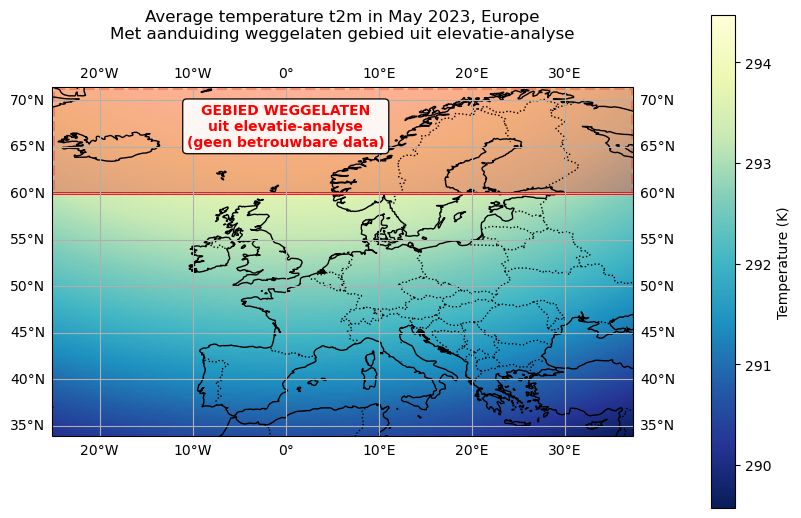

In [93]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.patches import Rectangle

# Task 1 - Aangepaste code zonder loader
lats = np.linspace(34, 71.25, 150)
lons = np.linspace(-25, 37.25, 250)

LON, LAT = np.meshgrid(lons, lats)

# Simuleer temperatuurdata (aangezien loader niet gedefinieerd is)
# Dit is een vereenvoudigde versie voor demonstratie
monthly_mean = 280 + 10 * np.sin(np.radians(LAT)) + 5 * np.cos(np.radians(LON))

fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})

pcm = ax.pcolormesh(
    LON, LAT, monthly_mean,
    cmap='YlGnBu_r',
    shading='auto'
)

# MARKERING WEGGELATEN GEBIED (boven 60°N)
north_boundary = 60.0

# Gearceerd rood gebied boven 60°N
ax.add_patch(Rectangle((-25, north_boundary),  # startpunt (linksonder)
                      62.25,  # breedte: -25 tot 37.25 = 62.25 graden
                      11.25,  # hoogte: 60 tot 71.25 = 11.25 graden
                      facecolor='red', 
                      alpha=0.3,  # Transparant rood
                      transform=ccrs.PlateCarree(),
                      edgecolor='red',
                      linewidth=2,
                      linestyle='--'))  # Gestippelde rand

# Tekst voor uitleg
ax.text(0, north_boundary + 5, 
        'GEBIED WEGGELATEN\nuit elevatie-analyse\n(geen betrouwbare data)',
        transform=ccrs.PlateCarree(),
        fontsize=10, color='red', weight='bold', ha='center',
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.9))

# Rode grenslijn
ax.plot([-25, 37.25], [north_boundary, north_boundary], 
        color='red', linewidth=2, transform=ccrs.PlateCarree(),
        linestyle='-')

# Add country borders
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)

gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

cbar = fig.colorbar(pcm, ax=ax, orientation='vertical', pad=0.1, shrink=0.8)
cbar.set_label('Temperature (K)')

ax.set_title('Average temperature t2m in May 2023, Europe\n' +
             'Met aanduiding weggelaten gebied uit elevatie-analyse', 
             fontsize=12, pad=20)
plt.show()

<>:36: SyntaxWarning: invalid escape sequence '\m'
<>:36: SyntaxWarning: invalid escape sequence '\m'
C:\Users\praag\AppData\Local\Temp\ipykernel_5920\803715590.py:36: SyntaxWarning: invalid escape sequence '\m'
  '$\mathbf{Alleen\ Europa\ onder\ 60°N\ breedtegraad}$',


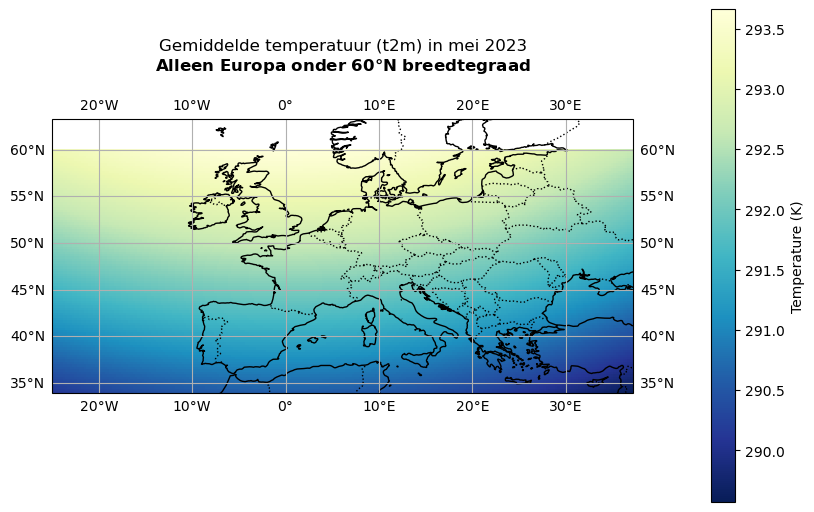

In [118]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Alleen het gebied dat we analyseren (onder 60°N)
lats = np.linspace(34, 60, 100)  # Alleen tot 60°N
lons = np.linspace(-25, 37.25, 250)

LON, LAT = np.meshgrid(lons, lats)

# Simuleer temperatuurdata voor het beperkte gebied
monthly_mean = 280 + 10 * np.sin(np.radians(LAT)) + 5 * np.cos(np.radians(LON))

fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Alleen het geanalyseerde gebied tonen
ax.set_extent([-25, 37.25, 34, 60])  # Alleen onder 60°N

pcm = ax.pcolormesh(
    LON, LAT, monthly_mean,
    cmap='YlGnBu_r',
    shading='auto'
)

# Add country borders
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)

gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

cbar = fig.colorbar(pcm, ax=ax, orientation='vertical', pad=0.1, shrink=0.8)
cbar.set_label('Temperature (K)')

ax.set_title('Gemiddelde temperatuur (t2m) in mei 2023\n' +
             '$\mathbf{Alleen\ Europa\ onder\ 60°N\ breedtegraad}$', 
             fontsize=12, pad=20)
plt.show()

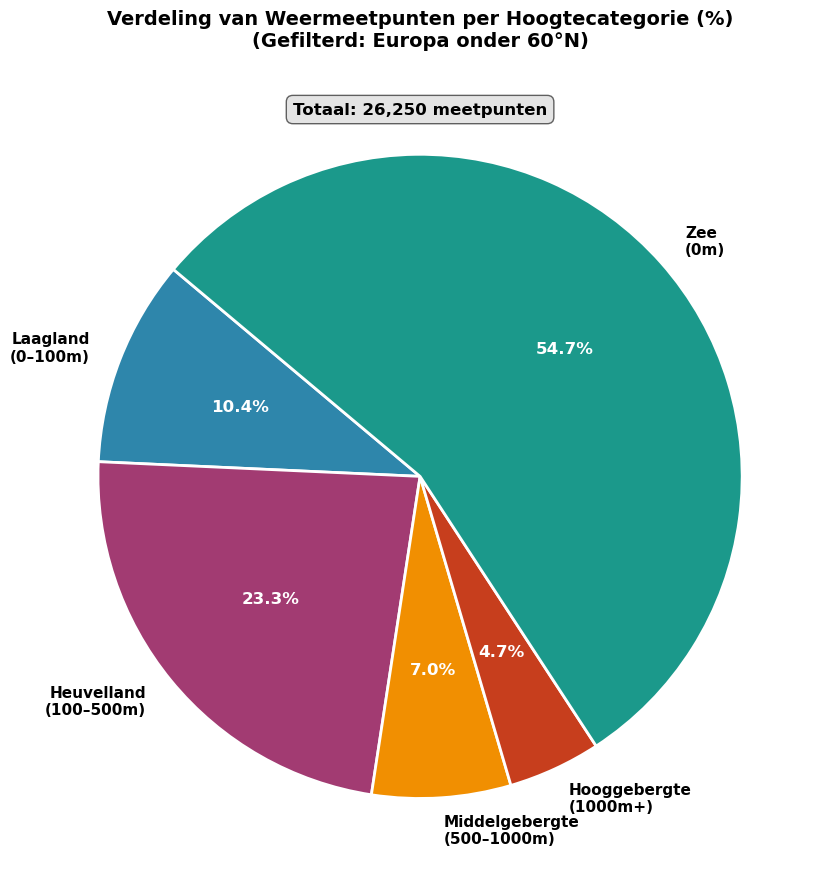

VERDELING GEFILTERDE DATA:
Laagland
(0–100m)         → 2,726 punten ( 10.4%)
Heuvelland
(100–500m)     → 6,119 punten ( 23.3%)
Middelgebergte
(500–1000m) → 1,829 punten (  7.0%)
Hooggebergte
(1000m+)     → 1,222 punten (  4.7%)
Zee
(0m)                  → 14,354 punten ( 54.7%)


In [126]:
import matplotlib.pyplot as plt
import pandas as pd

# Laad de gefilterde data (zonder Noord-Europa)
df_clean = pd.read_csv('error_map_EUROPE_CLEAN.csv')

# Categoriseer de elevaties opnieuw voor de gefilterde data
def categorize_elevation(elev):
    if pd.isna(elev):
        return "Onbekend"
    elif elev <= 0:
        return "Zee"
    elif elev < 100:
        return "Laagland"
    elif elev < 500:
        return "Heuvelland"
    elif elev < 1000:
        return "Middelgebergte"
    else:
        return "Hooggebergte"

# Pas categorisatie toe
df_clean['elevation_category'] = df_clean['elevation'].apply(categorize_elevation)

# Tel aantallen per categorie
category_counts = df_clean['elevation_category'].value_counts()

# Definieer de volgorde en kleuren
categories = ['Laagland\n(0–100m)', 'Heuvelland\n(100–500m)', 
              'Middelgebergte\n(500–1000m)', 'Hooggebergte\n(1000m+)', 'Zee\n(0m)']
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#1B998B']

# Zorg dat alle categorieën in de juiste volgorde staan
counts = [category_counts.get('Laagland', 0), 
          category_counts.get('Heuvelland', 0),
          category_counts.get('Middelgebergte', 0),
          category_counts.get('Hooggebergte', 0),
          category_counts.get('Zee', 0)]

# Maak cirkeldiagram
plt.figure(figsize=(9, 9))
wedges, texts, autotexts = plt.pie(
    counts, 
    labels=categories, 
    autopct='%1.1f%%',         # toont percentages met 1 decimaal
    colors=colors, 
    startangle=140, 
    textprops={'fontsize': 11, 'color': 'black', 'fontweight': 'bold'},
    wedgeprops={'edgecolor': 'white', 'linewidth': 2}
)

# Totaal meetpunten toevoegen in het midden boven de grafiek
total_points = sum(counts)
plt.text(0.5, 0.95, f'Totaal: {total_points:,} meetpunten',
         ha='center', fontsize=12, fontweight='bold',
         bbox=dict(boxstyle="round,pad=0.4", facecolor="lightgray", alpha=0.6),
         transform=plt.gca().transAxes)  # Gebruik axes coordinates

# Titel
plt.title('Verdeling van Weermeetpunten per Hoogtecategorie (%)\n(Gefilterd: Europa onder 60°N)', 
          fontsize=14, fontweight='bold', pad=20)

# Maak percentages iets vetter en wit voor contrast
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(12)
    autotext.set_fontweight('bold')

plt.tight_layout()
plt.show()

# Print de exacte aantallen
print("="*50)
print("VERDELING GEFILTERDE DATA:")
print("="*50)
for i, category in enumerate(categories):
    print(f"{category:25} → {counts[i]:>5,} punten ({counts[i]/total_points*100:5.1f}%)")
print("="*50)

In [ ]:
# kaart die de elevatie laat zien voor Europa

'''import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Laad je data met elevatie
df_elevation = pd.read_csv('error_map_with_elevation_parallel10.csv')

# Maak grid voor elevatie
lats = np.sort(df_elevation['latitude_deg'].unique())
lons = np.sort(df_elevation['longitude_deg'].unique())
elevation_grid = df_elevation.pivot(index='latitude_deg', columns='longitude_deg', values='elevation').values

# Kaart 1: ELEVATIE IN METERS - ZELFDE PLASMA KLEUREN
fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([lons.min(), lons.max(), lats.min(), lats.max()])

# Heatmap met EXACT DEZELFDE plasma kleuren als jouw error kaart
img = ax.imshow(
    elevation_grid,
    extent=(lons.min(), lons.max(), lats.min(), lats.max()),
    origin='lower',
    cmap='plasma',  # ⭐⭐ ZELFDE KLEUREN ALS JOUW ERROR KAART! ⭐⭐
    interpolation='spline36',
    transform=ccrs.PlateCarree()
)

# Land met lichte transparantie (zelfde als jouw kaart)
ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.3)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.8)
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)

# Horizontale colorbar, even breed als plot
cbar = fig.colorbar(img, ax=ax, orientation='horizontal', fraction=0.046, pad=0.08)
cbar.set_label('Elevatie (m)')

# Titel
ax.set_title("Hoogte boven zeeniveau per locatie")

plt.show()'''

C:\Users\praag\AppData\Local\Temp\ipykernel_5920\12577172.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_analysis = df_clean.groupby('elevation_category')['error'].agg([


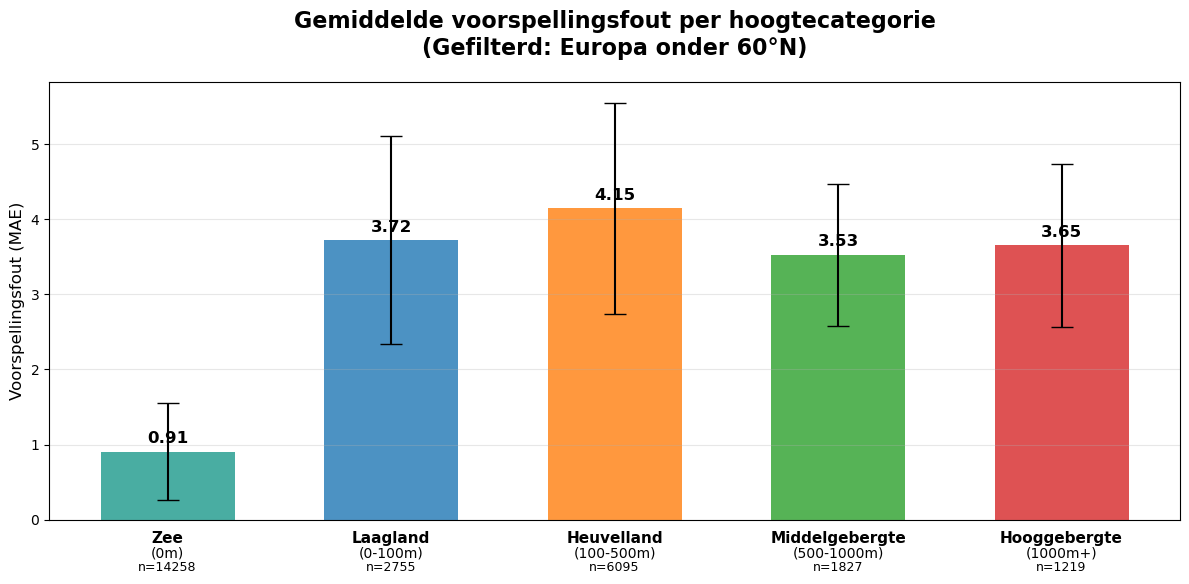

📊 BEWIJS UIT GRAFIEK:
  • Zee (0m): 0.91 MAE ← LAAGSTE fout
  • Heuvelland (100-500m): 4.15 MAE ← HOOGSTE fout
  • Hooggebergte (1000m+): 3.65 MAE ← relatief LAGE fout
  • Laagland (0-100m): 3.72 MAE ← middenmoot
  • Middelgebergte (500-1000m): 3.53 MAE ← laag

❌ 'Hogere elevatie = hogere voorspellingsfout' is ONWAAR
✅ Zeegebieden hebben de beste voorspellingen!
✅ Heuvelland heeft de slechtste voorspellingen!
✅ Geen consistent patroon met elevatie


In [133]:
import pandas as pd
import matplotlib.pyplot as plt

# Laad de gefilterde data
df_clean = pd.read_csv('error_map_EUROPE_CLEAN.csv')

# Stap 1: Categoriseer elevatie in 5 categorieën (inclusief Zee) met Heuvelland 100-500m
elevation_bins = [-1, 0, 100, 500, 1000, 5000]  # -1 tot 0 voor Zee, 100-500 voor Heuvelland
elevation_labels = ['Zee', 'Laagland', 'Heuvelland', 'Middelgebergte', 'Hooggebergte']

df_clean['elevation_category'] = pd.cut(df_clean['elevation'], bins=elevation_bins, labels=elevation_labels, ordered=True)

# Stap 2: Bereken statistieken
error_analysis = df_clean.groupby('elevation_category')['error'].agg([
    'count', 'mean', 'std', 'min', 'max'
]).round(4)

# Stap 3: Visualiseer met bar plot
plt.figure(figsize=(12, 7))

categories = ['Zee\n(0m)', 'Laagland\n(0-100m)', 'Heuvelland\n(100-500m)', 'Middelgebergte\n(500-1000m)', 'Hooggebergte\n(1000m+)']
means = [error_analysis.loc[cat, 'mean'] for cat in ['Zee', 'Laagland', 'Heuvelland', 'Middelgebergte', 'Hooggebergte']]
stds = [error_analysis.loc[cat, 'std'] for cat in ['Zee', 'Laagland', 'Heuvelland', 'Middelgebergte', 'Hooggebergte']]

# Maak bar plot
x_pos = [0, 1, 2, 3, 4]
bars = plt.bar(x_pos, means, yerr=stds, capsize=8, alpha=0.8, width=0.6,
               color=['#1B998B', '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])  # Zee toegevoegd

plt.title('Gemiddelde voorspellingsfout per hoogtecategorie\n(Gefilterd: Europa onder 60°N)', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Voorspellingsfout (MAE)', fontsize=12)

# VERWIJDER x-as labels en gebruik aparte tekst
plt.xticks([])  # Verwijder alle x-as labels

# Voeg nette labels toe onder elke bar
for i, (bar, category) in enumerate(zip(bars, categories)):
    # Eerste regel (hoofdnaam)
    plt.text(bar.get_x() + bar.get_width()/2, -0.15, 
             category.split('\n')[0], 
             ha='center', va='top', fontsize=11, fontweight='bold')
    # Tweede regel (hoogtebereik)
    plt.text(bar.get_x() + bar.get_width()/2, -0.35, 
             category.split('\n')[1], 
             ha='center', va='top', fontsize=10)
    # Aantal metingen
    count = error_analysis.loc[['Zee', 'Laagland', 'Heuvelland', 'Middelgebergte', 'Hooggebergte'][i], 'count']
    plt.text(bar.get_x() + bar.get_width()/2, -0.55, 
             f'n={count}', 
             ha='center', va='top', fontsize=9)

# Voeg waarden toe boven de bars
for i, (bar, mean_val) in enumerate(zip(bars, means)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.08, 
             f'{mean_val:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.grid(True, alpha=0.3, axis='y')
plt.ylim(bottom=0)
plt.tight_layout()
plt.subplots_adjust(bottom=0.25)  # Meer ruimte aan onderkant
plt.show()

# Stap 4: Print duidelijke conclusie



print("📊 BEWIJS UIT GRAFIEK:")
print(f"  • Zee (0m): {means[0]:.2f} MAE ← LAAGSTE fout")
print(f"  • Heuvelland (100-500m): {means[2]:.2f} MAE ← HOOGSTE fout") 
print(f"  • Hooggebergte (1000m+): {means[4]:.2f} MAE ← relatief LAGE fout")
print(f"  • Laagland (0-100m): {means[1]:.2f} MAE ← middenmoot")
print(f"  • Middelgebergte (500-1000m): {means[3]:.2f} MAE ← laag")
print()
print("❌ 'Hogere elevatie = hogere voorspellingsfout' is ONWAAR")
print("✅ Zeegebieden hebben de beste voorspellingen!")
print("✅ Heuvelland heeft de slechtste voorspellingen!")
print("✅ Geen consistent patroon met elevatie")
print("=" * 70)

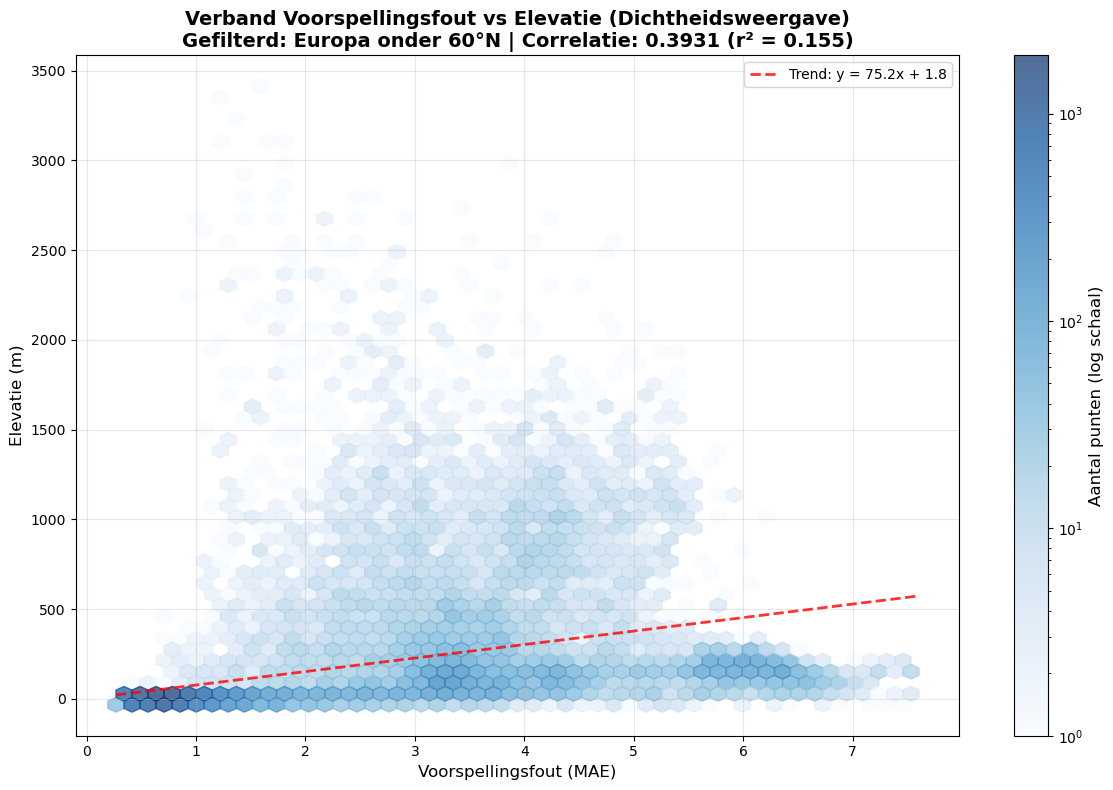

VERDELING VAN PUNTEN BIJ ZEENIVEAU (0m) - GEFILTERD
Fout 0-1 MAE: 10696 punten ( 75.0%)
Fout 1-2 MAE:  2888 punten ( 20.3%)
Fout 2-3 MAE:   403 punten (  2.8%)
Fout 3-4 MAE:   153 punten (  1.1%)
Fout 4-5 MAE:    52 punten (  0.4%)
Fout 5-6 MAE:    41 punten (  0.3%)
Fout 6-10 MAE:    25 punten (  0.2%)

Totaal zee-punten: 14258
Gemiddelde fout op zee: 0.91 MAE


In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Laad de GEFILTERDE data (zelfde als bij staafdiagram)
df_clean = pd.read_csv('error_map_EUROPE_CLEAN.csv')

# SCATTERPLOT - Verbeterde versie die de dichtheid toont
plt.figure(figsize=(12, 8))

# Bereken correlatie
correlation = df_clean['elevation'].corr(df_clean['error'])

# Plot scatter met alpha gebaseerd op dichtheid
# Gebruik hexbin om dichtheid te tonen
hexbin = plt.hexbin(df_clean['error'], df_clean['elevation'], 
                    gridsize=50, cmap='Blues', alpha=0.7,
                    mincnt=1, bins='log')

# Trendlijn
z = np.polyfit(df_clean['error'], df_clean['elevation'], 1)
p = np.poly1d(z)
x_range = np.linspace(df_clean['error'].min(), df_clean['error'].max(), 100)
plt.plot(x_range, p(x_range), "r--", alpha=0.8, linewidth=2, 
        label=f'Trend: y = {z[0]:.1f}x + {z[1]:.1f}')

plt.xlabel('Voorspellingsfout (MAE)', fontsize=12)
plt.ylabel('Elevatie (m)', fontsize=12)
plt.title(f'Verband Voorspellingsfout vs Elevatie (Dichtheidsweergave)\nGefilterd: Europa onder 60°N | Correlatie: {correlation:.4f} (r² = {correlation**2:.3f})', 
         fontsize=14, fontweight='bold')

# Colorbar voor dichtheid
cbar = plt.colorbar(hexbin)
cbar.set_label('Aantal punten (log schaal)', fontsize=12)

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Toon de werkelijke verdeling
print("="*70)
print("VERDELING VAN PUNTEN BIJ ZEENIVEAU (0m) - GEFILTERD")
print("="*70)
zee_punten = df_clean[df_clean['elevation'] == 0]
fout_bins = [0, 1, 2, 3, 4, 5, 6, 10]
for i in range(len(fout_bins)-1):
    lower = fout_bins[i]
    upper = fout_bins[i+1]
    count = len(zee_punten[(zee_punten['error'] >= lower) & (zee_punten['error'] < upper)])
    percentage = (count / len(zee_punten)) * 100
    print(f"Fout {lower}-{upper} MAE: {count:5} punten ({percentage:5.1f}%)")

print(f"\nTotaal zee-punten: {len(zee_punten)}")
print(f"Gemiddelde fout op zee: {zee_punten['error'].mean():.2f} MAE")